In [27]:
import numpy as np
import os
import torch
import torch.nn as nn
import time
import pandas as pd
from scipy.stats import pearsonr

In [ ]:
from model.util import Normalizer
from model.utils import get_hist_file, get_job_table_sample, collator
from model.utils import Encoding
from model.encodingupdated import QueryEncoding

In [ ]:
# Load the histogram file
hist_file = get_hist_file('histogram_string.csv')
# Normalizer for cost
cost_norm = Normalizer(-3.61192, 12.290855)
# Normalizer for cardinality
card_norm = Normalizer(1, 100)
# Normalizer for knob settings (if applicable)
knob_norm = Normalizer(0, 1)  # Adjust ranges based on your knob setting values


e:\KHU\Research\QueryFormer\QueryFormer\model\database_util.py:76: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hist_file['freq'][i] = freq_np
e:\KHU\Research\QueryFormer\QueryFormer\model\database_util.py:89: FutureWarning: ChainedAssignme

In [ ]:
encoding_ckpt = torch.load('checkpoints/encoding.pt', map_location='cpu', weights_only=False)  
encoding = encoding_ckpt['encoding']  # Extracts the 'encoding' object from the checkpoint.


In [33]:
if torch.cuda.is_available():
    x = torch.randn(3, 3).cuda()
    print(x)
else:
    print("CUDA is not available")

tensor([[ 0.8043, -0.6633,  1.2161],
        [ 1.1957,  1.3176,  0.0253],
        [ 0.5141,  0.9085,  1.0686]], device='cuda:0')


In [34]:
import torch
print(torch.cuda.get_device_name(0))


NVIDIA GeForce GTX 1050 Ti


In [ ]:

# file = imdb_path + 'plan_and_cost/tradata.csv'.format(i)
file ='dataset/traindata1'
full_train_df = pd.read_csv(file)
  
file = 'dataset/traindata1'
val_df = pd.read_csv(file)



In [ ]:
val_df

,id,json
0,50000,"{""Plan"": {""Node Type"": ""Gather"", ""Parallel Awa..."
1,50001,"{""Plan"": {""Node Type"": ""Gather"", ""Parallel Awa..."
2,50002,"{""Plan"": {""Node Type"": ""Index Scan"", ""Parallel..."
3,50003,"{""Plan"": {""Node Type"": ""Bitmap Heap Scan"", ""Pa..."
4,50004,"{""Plan"": {""Node Type"": ""Gather"", ""Parallel Awa..."
...,...,...
4995,54995,"{""Plan"": {""Node Type"": ""Gather"", ""Parallel Awa..."
4996,54996,"{""Plan"": {""Node Type"": ""Hash Join"", ""Parallel ..."
4997,54997,"{""Plan"": {""Node Type"": ""Bitmap Heap Scan"", ""Pa..."
4998,54998,"{""Plan"": {""Node Type"": ""Gather"", ""Parallel Awa..."


In [36]:
import pandas as pd
import numpy as np

# Load the dataset (assuming `full_train_df` is already created)
df = full_train_df.copy()

# Check for missing values
missing_values = df.isnull().sum()

# Get basic statistics
basic_stats = df.describe()

# Display results
print("Missing Values:\n", missing_values)
print("\nBasic Statistics:\n", basic_stats)



Missing Values:
 id      0
json    0
dtype: int64

Basic Statistics:
                  id
count  25000.000000
mean   12499.500000
std     7217.022701
min        0.000000
25%     6249.750000
50%    12499.500000
75%    18749.250000
max    24999.000000


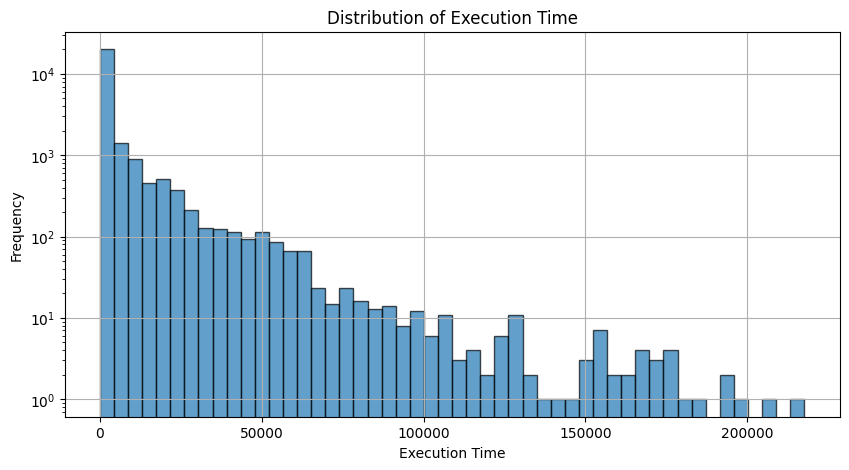

count     25000.000000
mean       5025.913011
std       13265.634122
min           0.031000
25%         182.952000
50%         681.894000
75%        3088.926750
max      217696.059000
Name: Execution_Time, dtype: float64

In [37]:
import json
import matplotlib.pyplot as plt

# Extract Execution Time from JSON column
full_train_df['Execution_Time'] = full_train_df['json'].apply(lambda x: json.loads(x).get('Execution Time', 0))

# Plot the distribution
plt.figure(figsize=(10, 5))
plt.hist(full_train_df['Execution_Time'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Execution Time')
plt.ylabel('Frequency')
plt.title('Distribution of Execution Time')
plt.yscale('log')  # Log scale to handle large variance
plt.grid(True)
plt.show()

# Summary statistics for Execution Time
execution_time_stats = full_train_df['Execution_Time'].describe()
execution_time_stats


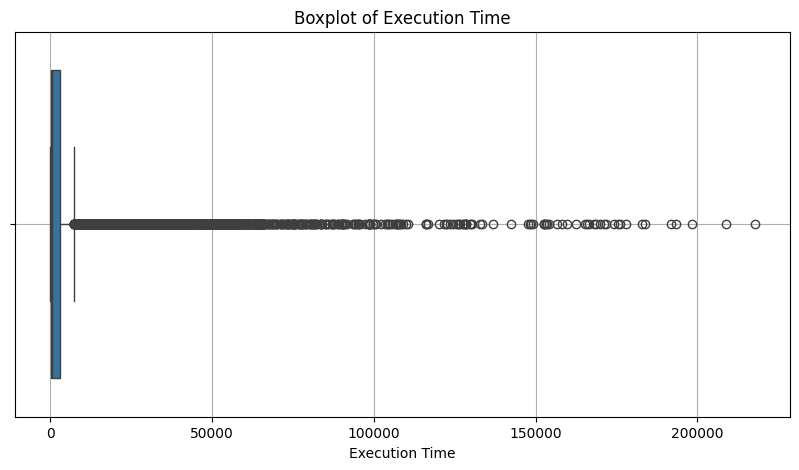

Number of outliers in Execution Time: 3832
Outlier Thresholds: Lower = -4176.010125, Upper = 7447.888875000001


In [38]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.boxplot(x=full_train_df['Execution_Time'])
plt.xlabel('Execution Time')
plt.title('Boxplot of Execution Time')
plt.grid(True)
plt.show()

# Identifying outliers using IQR (Interquartile Range)
Q1 = full_train_df['Execution_Time'].quantile(0.25)
Q3 = full_train_df['Execution_Time'].quantile(0.75)
IQR = Q3 - Q1
outliers = full_train_df[(full_train_df['Execution_Time'] < (Q1 - 1.5 * IQR)) | 
                         (full_train_df['Execution_Time'] > (Q3 + 1.5 * IQR))]

# Print number of outliers
print(f"Number of outliers in Execution Time: {len(outliers)}")
print(f"Outlier Thresholds: Lower = {Q1 - 1.5 * IQR}, Upper = {Q3 + 1.5 * IQR}")


In [39]:
import json

# Function to extract numerical features from the 'json' column
def extract_features(plan_json):
    if isinstance(plan_json, str):
        plan_dict = json.loads(plan_json)  # Convert string to dictionary
    else:
        plan_dict = plan_json

    # Extract relevant numerical features
    return {
        "Execution_Time": plan_dict.get("Execution Time", 0),
        "Startup_Cost": plan_dict["Plan"].get("Startup Cost", 0),
        "Total_Cost": plan_dict["Plan"].get("Total Cost", 0),
        "Plan_Rows": plan_dict["Plan"].get("Plan Rows", 0),
        "Plan_Width": plan_dict["Plan"].get("Plan Width", 0),
        "Actual_Startup_Time": plan_dict["Plan"].get("Actual Startup Time", 0),
        "Actual_Total_Time": plan_dict["Plan"].get("Actual Total Time", 0),
        "Actual_Rows": plan_dict["Plan"].get("Actual Rows", 0),
        "Actual_Loops": plan_dict["Plan"].get("Actual Loops", 0)
    }

# Apply feature extraction to the dataset
extracted_features = full_train_df["json"].apply(extract_features).apply(pd.Series)

# Merge extracted features with the original DataFrame
full_train_df = pd.concat([full_train_df, extracted_features], axis=1)

# Drop the original 'json' column since we extracted relevant numerical features
full_train_df.drop(columns=["json"], inplace=True)

print(full_train_df.head())  # Verify the extracted features


   id  Execution_Time  Execution_Time  Startup_Cost  Total_Cost  Plan_Rows  \
0   0         654.241         654.241      23540.58   154548.95   567655.0   
1   1         349.797         349.797          0.00    67602.30  1116092.0   
2   2        1699.240        1699.240          0.00   347461.15  3700158.0   
3   3         345.056         345.056      22727.12    87837.10   130827.0   
4   4          90.666          90.666        725.65    25968.71    63125.0   

   Plan_Width  Actual_Startup_Time  Actual_Total_Time  Actual_Rows  \
0       119.0              386.847            646.972     283812.0   
1        94.0                0.035            322.837    1107925.0   
2        74.0              188.050           1611.147    3624977.0   
3       134.0               67.080            341.561     134807.0   
4        12.0                4.896             89.198      54826.0   

   Actual_Loops  
0           1.0  
1           1.0  
2           1.0  
3           1.0  
4           1.0  


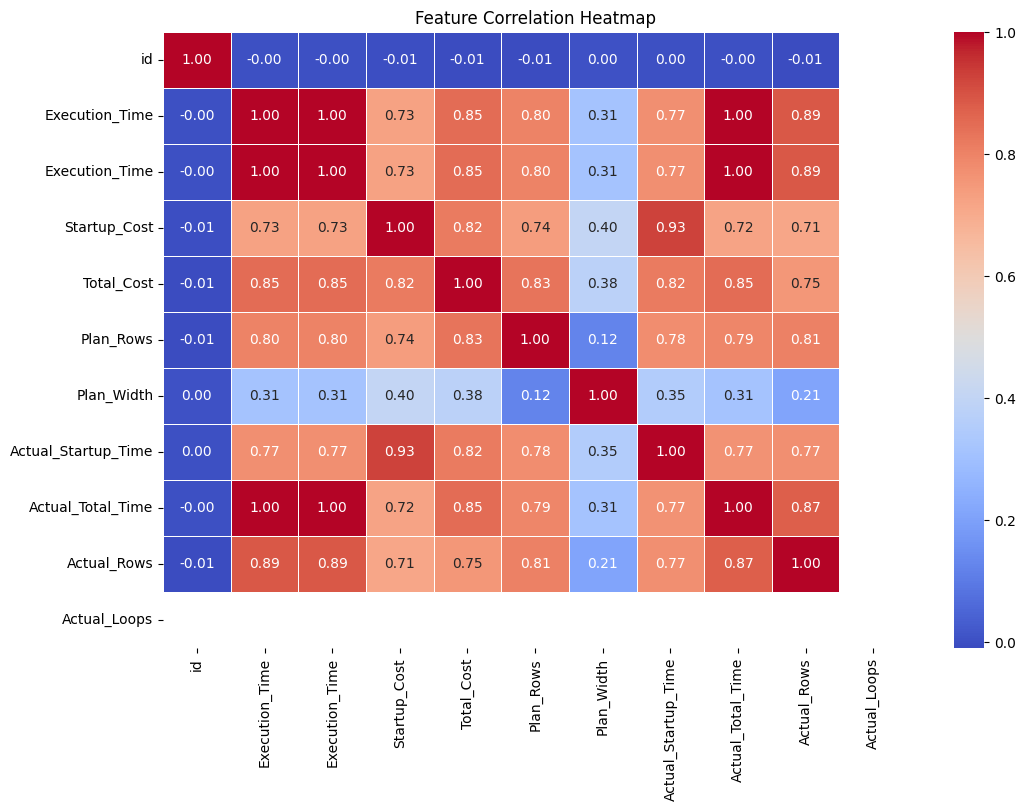

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = full_train_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
table_sample = get_job_table_sample('trainsample')

Loaded queries with len  100000
Loaded bitmaps


In [177]:
to_predict = 'both'

In [ ]:
train_ds = QueryEncoding(full_train_df, None, encoding, hist_file, card_norm, cost_norm, to_predict, table_sample)
val_ds = QueryEncoding(val_df, None, encoding, hist_file, card_norm, cost_norm, to_predict, table_sample)

total execution time is : [654.241, 349.797, 1699.24, 345.056, 90.666, 1969.649, 451.819, 2872.724, 139.463, 2214.235, 1.414, 3496.242, 649.467, 646.799, 23787.31, 196.909, 2266.655, 438.686, 1678.835, 0.776, 28375.78, 4961.93, 683.408, 25946.054, 5368.257, 137.316, 901.97, 33524.11, 2.013, 1872.677, 1859.47, 1057.436, 9238.746, 501.543, 81.169, 1130.371, 188.843, 2075.724, 237.18, 629.351, 86.789, 53.271, 2717.458, 3489.762, 64358.913, 183.124, 362.449, 815.734, 148.9, 334.124, 2281.611, 5325.259, 14.722, 1456.748, 581.675, 3303.989, 1742.95, 681.213, 518.583, 442.769, 479.335, 453.461, 333.692, 150.929, 38707.084, 2318.295, 3.218, 8996.805, 277.55, 115.186, 2459.453, 1754.914, 207.698, 0.076, 2459.465, 1000.224, 4020.684, 12236.215, 25707.377, 9473.649, 9118.74, 63.3, 1724.514, 3473.579, 162.881, 625.256, 296.791, 884.029, 38182.889, 1616.55, 9252.593, 314.834, 73.787, 57.645, 1829.444, 2419.735, 108.203, 442.197, 5788.987, 882.549, 2584.18, 32505.245, 265.438, 1824.419, 2680.292, 32

In [179]:
def save_train_dataset_to_csv(train_ds, filename):
    rows = []

    for i in range(len(train_ds)):
        # Extract collated_dicts and labels
        features, (cost_label, hint_label) = train_ds[i]
        
        # Flatten features for easier CSV representation
        features_flattened = {f"feature_{j}": value for j, value in enumerate(features['x'].flatten().numpy())}
        
        # Add cost label
        features_flattened['cost_label'] = cost_label.item()  # This works because cost_label is a scalar
        
        # Convert hint_label (knob settings) to a list and store it as a string
        features_flattened['hint_label'] = ",".join(map(str, hint_label.numpy().tolist()))  
        
        rows.append(features_flattened)
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    
    # Save to CSV
    df.to_csv(filename, index=False)
    print(f"Training dataset saved to {filename}")


In [184]:
val_df

,id,json
0,50000,"{""Plan"": {""Node Type"": ""Gather"", ""Parallel Awa..."
1,50001,"{""Plan"": {""Node Type"": ""Gather"", ""Parallel Awa..."
2,50002,"{""Plan"": {""Node Type"": ""Index Scan"", ""Parallel..."
3,50003,"{""Plan"": {""Node Type"": ""Bitmap Heap Scan"", ""Pa..."
4,50004,"{""Plan"": {""Node Type"": ""Gather"", ""Parallel Awa..."
...,...,...
4995,54995,"{""Plan"": {""Node Type"": ""Gather"", ""Parallel Awa..."
4996,54996,"{""Plan"": {""Node Type"": ""Hash Join"", ""Parallel ..."
4997,54997,"{""Plan"": {""Node Type"": ""Bitmap Heap Scan"", ""Pa..."
4998,54998,"{""Plan"": {""Node Type"": ""Gather"", ""Parallel Awa..."


In [ ]:
# save_train_dataset_to_csv(train_ds, "out/trainU10_dataset.csv")
# save_train_dataset_to_csv(val_ds, "out/validationdata.csv")

Training dataset saved to out/validationdata.csv


In [186]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier


def read_csv(file_path):
    data = pd.read_csv(file_path)
    return data

def extract_features_labels(data, label_column):
    X = data.drop(columns=[label_column])  # Features
    y = data[label_column]                 # Labels
    return X, y

def extract_features_labels2(data, hint_label_column, cost_label_column):
    X = data.drop(columns=[hint_label_column, cost_label_column])  # Keep features
    y_hints = data[hint_label_column]  # Hint Labels
    y_costs = data[cost_label_column]  # Cost Labels
    return X, y_hints, y_costs

def preprocess_features(X):
    # Standardize features for SVM (if numerical)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

# Train Gradient Boosting Classifier
def train_gradient_boosting(X_train, y_train):
    gbc = GradientBoostingClassifier(random_state=42)
    gbc.fit(X_train, y_train)
    return gbc

In [71]:
file_path = "out/trainU10_dataset.csv"
hint_label_column = "hint_label"
cost_label_column = "cost_label"  # Ensure this column exists in CSV

data = read_csv(file_path)
X, y_hints, y_costs = extract_features_labels2(data, hint_label_column, cost_label_column)


In [264]:
file_path = "out/validationdata.csv"
hint_label_column = "hint_label"
cost_label_column = "cost_label"  # Ensure this column exists in CSV

valdata = read_csv(file_path)
X_val, y_hints_val, y_costs_val = extract_features_labels2(valdata, hint_label_column, cost_label_column)


In [265]:
y_hints_val

0       0.0,47.0,20.0,32.0,33.0,22.0,23.0,23.0,23.0,23...
1       0.0,19.0,20.0,48.0,18.0,18.0,18.0,18.0,18.0,18...
2       7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....
3       4.0,24.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14...
4       0.0,19.0,20.0,17.0,18.0,18.0,18.0,18.0,18.0,18...
                              ...                        
4995    0.0,19.0,20.0,17.0,18.0,18.0,18.0,18.0,18.0,18...
4996    1.0,15.0,13.0,14.0,14.0,14.0,14.0,14.0,14.0,14...
4997    4.0,24.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14...
4998    0.0,47.0,20.0,27.0,28.0,23.0,23.0,23.0,23.0,23...
4999    1.0,15.0,46.0,14.0,14.0,14.0,14.0,14.0,14.0,14...
Name: hint_label, Length: 5000, dtype: object

In [266]:
data

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_34942,feature_34943,feature_34944,feature_34945,feature_34946,feature_34947,feature_34948,feature_34949,cost_label,hint_label
0,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.634820,"0.0,19.0,20.0,17.0,18.0,18.0,18.0,18.0,18.0,18..."
1,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.892086,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.595448,"2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
2,2.0,0.0,13.0,0.0,0.0,2.0,0.0,0.0,0.027523,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.694838,"2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
3,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.594590,"0.0,19.0,20.0,17.0,18.0,18.0,18.0,18.0,18.0,18..."
4,4.0,0.0,19.0,0.0,0.0,2.0,0.0,0.0,0.000402,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.510547,"4.0,24.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,7.0,0.0,10.0,9.0,0.0,0.0,1.0,0.0,0.100000,0.865876,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.049155,"7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
4996,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.689908,"0.0,19.0,20.0,17.0,18.0,18.0,18.0,18.0,18.0,18..."
4997,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.694614,"0.0,19.0,20.0,17.0,18.0,18.0,18.0,18.0,18.0,18..."
4998,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.787670,"0.0,19.0,20.0,17.0,18.0,18.0,18.0,18.0,18.0,18..."


In [267]:
# Convert X to DataFrame to use isnull
X_df = pd.DataFrame(X)
X_vdf=pd.DataFrame(X_val)
# Check if there are any missing values in the dataset
print(f"Missing values before scaling: {X_df.isnull().sum().sum()}")

Missing values before scaling: 0


In [268]:
y_hints_val

0       0.0,47.0,20.0,32.0,33.0,22.0,23.0,23.0,23.0,23...
1       0.0,19.0,20.0,48.0,18.0,18.0,18.0,18.0,18.0,18...
2       7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....
3       4.0,24.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14...
4       0.0,19.0,20.0,17.0,18.0,18.0,18.0,18.0,18.0,18...
                              ...                        
4995    0.0,19.0,20.0,17.0,18.0,18.0,18.0,18.0,18.0,18...
4996    1.0,15.0,13.0,14.0,14.0,14.0,14.0,14.0,14.0,14...
4997    4.0,24.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14...
4998    0.0,47.0,20.0,27.0,28.0,23.0,23.0,23.0,23.0,23...
4999    1.0,15.0,46.0,14.0,14.0,14.0,14.0,14.0,14.0,14...
Name: hint_label, Length: 5000, dtype: object

In [270]:
# Preprocess features
X = preprocess_features(X)
X_val=preprocess_features(X_val)



In [271]:
y_hints_val

0       0.0,47.0,20.0,32.0,33.0,22.0,23.0,23.0,23.0,23...
1       0.0,19.0,20.0,48.0,18.0,18.0,18.0,18.0,18.0,18...
2       7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....
3       4.0,24.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14...
4       0.0,19.0,20.0,17.0,18.0,18.0,18.0,18.0,18.0,18...
                              ...                        
4995    0.0,19.0,20.0,17.0,18.0,18.0,18.0,18.0,18.0,18...
4996    1.0,15.0,13.0,14.0,14.0,14.0,14.0,14.0,14.0,14...
4997    4.0,24.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14...
4998    0.0,47.0,20.0,27.0,28.0,23.0,23.0,23.0,23.0,23...
4999    1.0,15.0,46.0,14.0,14.0,14.0,14.0,14.0,14.0,14...
Name: hint_label, Length: 5000, dtype: object

In [221]:
from sklearn.model_selection import train_test_split

# Splitting into training and testing sets for both hint labels and cost labels
X_train, X_test, y_hints_train, y_hints_test, y_cost_train, y_cost_test = train_test_split(
    X, y_hints, y_costs, test_size=0.2, random_state=42
)


In [222]:
# Convert to sets for strict comparison
train_tuples = set(map(tuple, X_train))
test_tuples = set(map(tuple, X_test))

# Find exact intersection (should be 0)
overlap = train_tuples & test_tuples
print(f"New Train-Test Overlap: {len(overlap)}") 

New Train-Test Overlap: 0


In [223]:
X_val.size

174750000

In [273]:
import numpy as np
import pandas as pd

def process_labels(y):
    if isinstance(y, pd.Series):
        y = y.astype(str).tolist()  # Convert Series to a list of strings
    elif isinstance(y, np.ndarray):
        y = y.tolist()  # Convert NumPy array to a list

    processed_labels = []
    for label in y:
        try:
            # Convert each entry from a comma-separated string to a list of floats
            processed_labels.append(list(map(float, label.split(','))) if isinstance(label, str) else label)
        except ValueError:
            print(f"Error processing label: {label}")  # Debugging
            processed_labels.append([])  # Handle incorrect formats safely

    # Convert to a NumPy array with dtype=float for multi-label compatibility
    return np.array(processed_labels, dtype=np.float32)



In [274]:

# Process labels for multi-label compatibility
y_hints_train = process_labels(y_hints_train)
y_hints_test = process_labels(y_hints_test)
y_cost_train = process_labels(y_cost_train)
y_cost_test = process_labels(y_cost_test)

y_hints_val=process_labels(y_hints_val)
y_costs_val=process_labels(y_costs_val)

# Verify shapes
# print("X_train shape:", X_train.shape)
# print("X_test shape:", X_test.shape)
# print("y_hints_train shape:", y_hints_train.shape)
# print("y_hints_test shape:", y_hints_test.shape)
# print("y_cost_train shape:", y_cost_train.shape)
# print("y_cost_test shape:", y_cost_test.shape)


In [276]:
# Ensure y_hints and y_costs are NumPy arrays
y_hints_train = np.array(y_hints_train).astype(int)  # Convert to integer labels
y_hints_test = np.array(y_hints_test).astype(int)
y_cost_train = np.array(y_cost_train).astype(float)  # Cost values should be float
y_cost_test = np.array(y_cost_test).astype(float)

y_hints_val=np.array(y_hints_val).astype(int)
y_costs_val=np.array(y_costs_val).astype(float)

if len(y_hints_val.shape) > 1:
    y_hints_val = y_hints_val.argmax(axis=1)  # Convert multi-label to single-label
# Ensure single-class labels for hints (not multi-label lists)
if len(y_hints_train.shape) > 1:
    y_hints_train = y_hints_train.argmax(axis=1)  # Convert multi-label to single-label
if len(y_hints_test.shape) > 1:
    y_hints_test = y_hints_test.argmax(axis=1)

# Print shape verification
print("y_hints_train shape:", y_hints_train.shape)
print("y_hints_test shape:", y_hints_test.shape)
print("y_cost_train shape:", y_cost_train.shape)
print("y_cost_test shape:", y_cost_test.shape)
print("y_hints_val shape:", y_hints_val.shape)
print("y_costs_val shape:", y_costs_val.shape)


y_hints_train shape: (4000,)
y_hints_test shape: (1000,)
y_cost_train shape: (4000, 1)
y_cost_test shape: (1000, 1)
y_hints_val shape: (5000,)
y_costs_val shape: (5000, 1)


In [279]:
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_hints_val_tensor = torch.tensor(y_hints_val, dtype=torch.long)
y_cost_val_tensor = torch.tensor(y_costs_val, dtype=torch.float32).unsqueeze(1)


New Update Temp

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import r2_score
import time

from hybridmodel import QueryOptimizerModel

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_hints_train_tensor = torch.tensor(y_hints_train, dtype=torch.long)
y_cost_train_tensor = torch.tensor(y_cost_train, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_hints_test_tensor = torch.tensor(y_hints_test, dtype=torch.long)
y_cost_test_tensor = torch.tensor(y_cost_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_data = TensorDataset(X_train_tensor, y_hints_train_tensor, y_cost_train_tensor)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

num_hints = y_hints_train_tensor.max().item() + 1

# Enhanced Model
model = QueryOptimizerModel(input_size=X_train.shape[1], hidden_size=256, num_hints=num_hints, num_outputs=1)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, hint_pred, target):
        assert hint_pred.shape == target.shape, f"Shape mismatch: {hint_pred.shape} vs {target.shape}"
        similarity = F.cosine_similarity(hint_pred, target, dim=1)
        loss = torch.mean((1 - similarity) ** 2)
        return loss

hint_criterion = FocalLoss()
contrastive_loss = ContrastiveLoss()
cost_criterion = nn.MSELoss()

# Optimizer & Scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.0002, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

# Dynamic Cost-Aware Prioritization
def compute_weights(costs, alpha=5.0, beta=0.5):
    normalized_costs = (costs - costs.mean()) / (costs.std() + 1e-8)
    weights = torch.exp(-alpha * normalized_costs) + beta
    return weights / torch.sum(weights)

# Training Loop
num_epochs = 50
epoch_times, total_losses = [], []
train_losses, train_accuracies, train_cost_losses, epoch_costs, cost_history, train_r2_scores = [], [], [], [], [], []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    epoch_loss, epoch_cost_loss, correct, total = 0.0, 0.0, 0, 0
    all_cost_preds, all_cost_targets = [], []

    for inputs, hints, costs in train_loader:
        optimizer.zero_grad()
        
        hint_outputs, cost_outputs = model(inputs)
        costs = costs.squeeze(1)  # Fix: Remove extra dimension to match cost_outputs [batch_size, 1]
        weights = compute_weights(costs)

        hint_loss = hint_criterion(hint_outputs, hints)
        cost_loss = cost_criterion(cost_outputs, costs)  # Now shapes match
        target_one_hot = F.one_hot(hints, num_classes=hint_outputs.shape[1]).float()
        contrastive_hint_loss = contrastive_loss(hint_outputs, target_one_hot)
        total_loss = torch.mean(weights * (0.8 * hint_loss + 0.6 * cost_loss + 0.05 * contrastive_hint_loss))

        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item() * inputs.size(0)
        epoch_cost_loss += cost_loss.item() * inputs.size(0)
        
        epoch_costs.extend(costs.detach().cpu().numpy().flatten().tolist())
        all_cost_preds.extend(cost_outputs.detach().cpu().numpy().flatten().tolist())
        all_cost_targets.extend(costs.detach().cpu().numpy().flatten().tolist())
        
        _, predicted = torch.max(hint_outputs, 1)
        correct += (predicted == hints).sum().item()
        total += hints.size(0)

    avg_loss = epoch_loss / total
    avg_cost_loss = epoch_cost_loss / total
    accuracy = correct / total
    train_r2 = r2_score(all_cost_targets, all_cost_preds)

    total_losses.append(avg_loss)
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    train_cost_losses.append(avg_cost_loss)
    cost_history.append(epoch_costs)
    train_r2_scores.append(train_r2)

    scheduler.step()
    epoch_time = time.time() - start_time
    epoch_times.append(epoch_time)

    print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {avg_loss:.4f}, '
          f'Hint Accuracy: {accuracy*100:.2f}%, Cost Loss (MSE): {avg_cost_loss:.4f}')

# Evaluation on Test Set
model.eval()
with torch.no_grad():
    hint_outputs, cost_outputs = model(X_test_tensor)
    y_cost_test_tensor = y_cost_test_tensor.squeeze(1)  # Fix: Match cost_outputs shape

    _, predicted = torch.max(hint_outputs, 1)
    hint_accuracy = (predicted == y_hints_test_tensor).sum().item() / y_hints_test_tensor.size(0)
    cost_mae = torch.abs(cost_outputs - y_cost_test_tensor).mean().item()
    test_r2 = r2_score(y_cost_test_tensor.cpu().numpy().flatten(), cost_outputs.cpu().numpy().flatten())

    print(f"Test Hint Accuracy: {hint_accuracy * 100:.2f}%")
    print(f"Test Cost MAE: {cost_mae:.4f}")
    print(f"Test Cost R²: {test_r2:.4f}")

Epoch [1/50], Total Loss: 0.0095, Hint Accuracy: 61.38%, Cost Loss (MSE): 0.1269
Epoch [2/50], Total Loss: 0.0043, Hint Accuracy: 75.38%, Cost Loss (MSE): 0.0922
Epoch [3/50], Total Loss: 0.0033, Hint Accuracy: 78.03%, Cost Loss (MSE): 0.0784
Epoch [4/50], Total Loss: 0.0027, Hint Accuracy: 81.50%, Cost Loss (MSE): 0.0685
Epoch [5/50], Total Loss: 0.0025, Hint Accuracy: 81.53%, Cost Loss (MSE): 0.0645
Epoch [6/50], Total Loss: 0.0024, Hint Accuracy: 82.38%, Cost Loss (MSE): 0.0589
Epoch [7/50], Total Loss: 0.0024, Hint Accuracy: 81.30%, Cost Loss (MSE): 0.0545
Epoch [8/50], Total Loss: 0.0021, Hint Accuracy: 83.70%, Cost Loss (MSE): 0.0509
Epoch [9/50], Total Loss: 0.0019, Hint Accuracy: 84.33%, Cost Loss (MSE): 0.0492
Epoch [10/50], Total Loss: 0.0018, Hint Accuracy: 85.52%, Cost Loss (MSE): 0.0444
Epoch [11/50], Total Loss: 0.0017, Hint Accuracy: 86.70%, Cost Loss (MSE): 0.0421
Epoch [12/50], Total Loss: 0.0016, Hint Accuracy: 85.95%, Cost Loss (MSE): 0.0393
Epoch [13/50], Total Loss

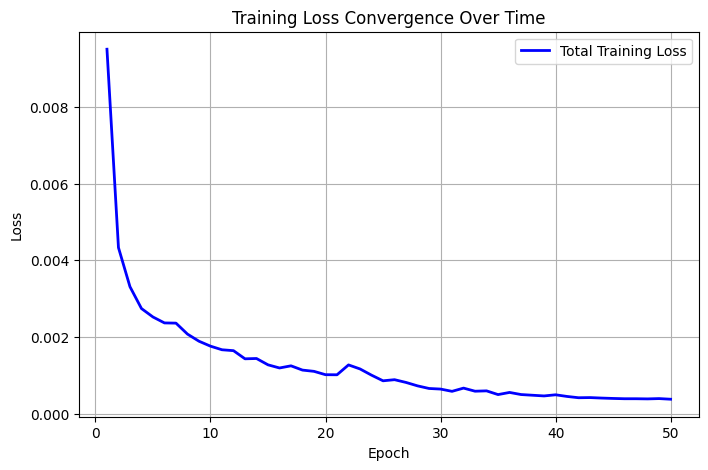

In [85]:
import matplotlib.pyplot as plt
import numpy as np
# **Plot Training Loss Convergence**
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), total_losses, label="Total Training Loss", color='blue', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Convergence Over Time")
plt.legend()
plt.grid(True)
plt.show()


🔍 Best Predictions (Lowest Error):
Actual Cost: 0.76, Predicted Cost: 0.76, Error: 0.00
Actual Cost: 0.70, Predicted Cost: 0.70, Error: 0.00
Actual Cost: 0.91, Predicted Cost: 0.91, Error: 0.00
Actual Cost: 0.35, Predicted Cost: 0.35, Error: 0.00
Actual Cost: 0.71, Predicted Cost: 0.71, Error: 0.00
Actual Cost: 0.63, Predicted Cost: 0.63, Error: 0.00
Actual Cost: 0.58, Predicted Cost: 0.59, Error: 0.00
Actual Cost: 0.55, Predicted Cost: 0.55, Error: 0.00
Actual Cost: 0.69, Predicted Cost: 0.69, Error: 0.00
Actual Cost: 0.72, Predicted Cost: 0.72, Error: 0.00

⚠️ Worst Predictions (Highest Error):
Actual Cost: 0.70, Predicted Cost: 0.40, Error: 0.30
Actual Cost: 0.17, Predicted Cost: 0.47, Error: 0.30
Actual Cost: 0.18, Predicted Cost: 0.49, Error: 0.30
Actual Cost: 0.58, Predicted Cost: 0.26, Error: 0.32
Actual Cost: 0.17, Predicted Cost: 0.49, Error: 0.32
Actual Cost: 0.74, Predicted Cost: 0.42, Error: 0.32
Actual Cost: 0.53, Predicted Cost: 0.21, Error: 0.32
Actual Cost: 0.70, Predi

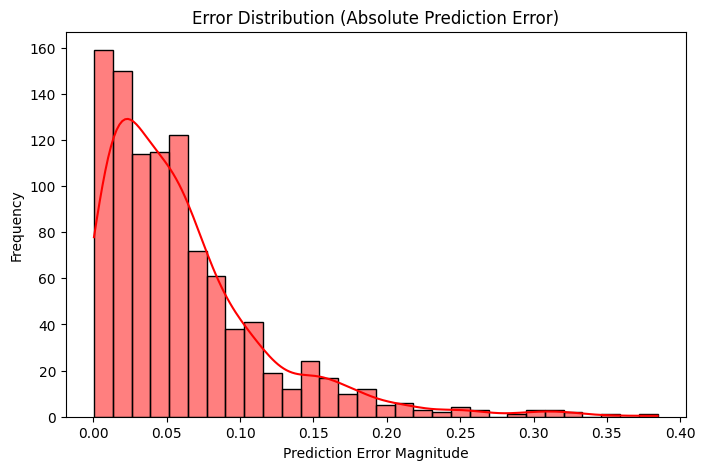

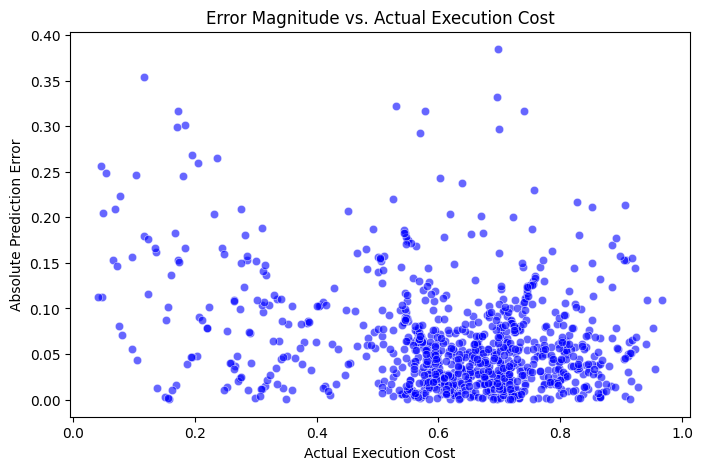

In [86]:

# Convert tensors to numpy arrays
y_hints_pred = predicted.cpu().numpy()
y_hints_true = y_hints_test_tensor.cpu().numpy()
cost_predicted = cost_outputs.cpu().numpy().flatten()
y_cost_true = y_cost_test_tensor.cpu().numpy().flatten()

# 🔹 1️⃣ Identify Best vs. Worst Performing Predictions
error_magnitude = np.abs(y_cost_true - cost_predicted)  # Absolute error
sorted_indices = np.argsort(error_magnitude)  # Sort indices by error

best_cases = sorted_indices[:10]  # Smallest errors (best predictions)
worst_cases = sorted_indices[-10:]  # Largest errors (worst predictions)

print("\n🔍 Best Predictions (Lowest Error):")
for i in best_cases:
    print(f"Actual Cost: {y_cost_true[i]:.2f}, Predicted Cost: {cost_predicted[i]:.2f}, Error: {error_magnitude[i]:.2f}")

print("\n⚠️ Worst Predictions (Highest Error):")
for i in worst_cases:
    print(f"Actual Cost: {y_cost_true[i]:.2f}, Predicted Cost: {cost_predicted[i]:.2f}, Error: {error_magnitude[i]:.2f}")

# 🔹 2️⃣ Error Distribution Plot
plt.figure(figsize=(8, 5))
sns.histplot(error_magnitude, bins=30, kde=True, color='red')
plt.title("Error Distribution (Absolute Prediction Error)")
plt.xlabel("Prediction Error Magnitude")
plt.ylabel("Frequency")
plt.show()

# 🔹 3️⃣ Error vs. Actual Cost Scatter Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_cost_true, y=error_magnitude, alpha=0.6, color='blue')
plt.title("Error Magnitude vs. Actual Execution Cost")
plt.xlabel("Actual Execution Cost")
plt.ylabel("Absolute Prediction Error")
plt.show()



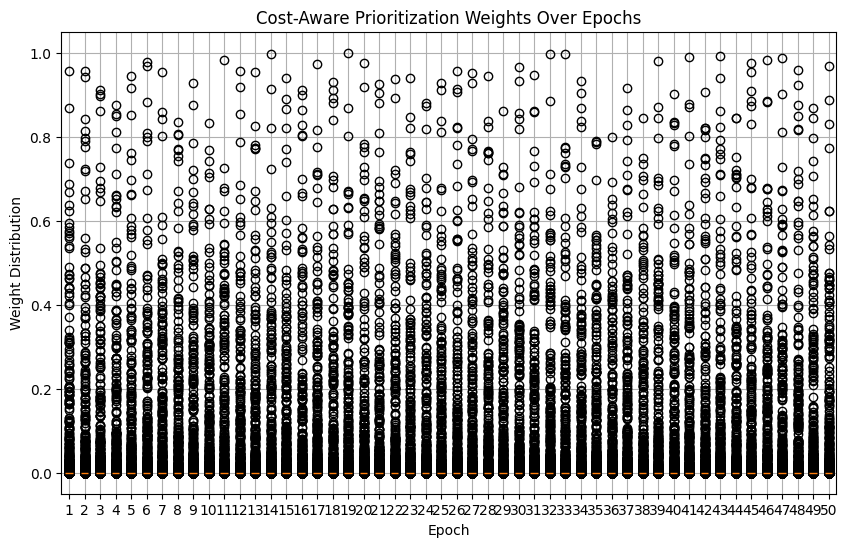

In [87]:
import matplotlib.pyplot as plt
import numpy as np

weight_history = []  # Store weight distributions

for epoch in range(num_epochs):
    epoch_weights = []

    for inputs, hints, costs in train_loader:
        weights = compute_weights(costs)
        epoch_weights.extend(weights.detach().cpu().numpy().flatten().tolist())  # Ensure 1D list

    weight_history.append(epoch_weights)  # Ensure list of lists

# Convert weight_history to a list of lists for plotting
weight_history = [np.array(epoch_weights).flatten().tolist() for epoch_weights in weight_history]

# **Plot Weight Distribution Over Epochs**
plt.figure(figsize=(10, 6))
plt.boxplot(weight_history, vert=True, patch_artist=True)
plt.xlabel("Epoch")
plt.ylabel("Weight Distribution")
plt.title("Cost-Aware Prioritization Weights Over Epochs")
plt.grid(True)
plt.show()


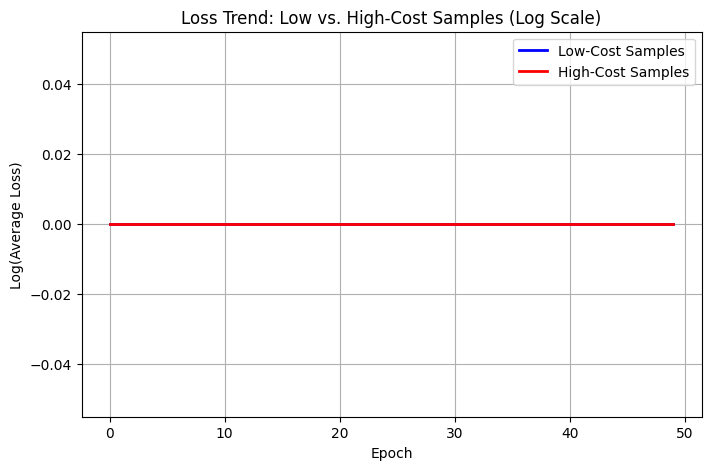

In [88]:
import matplotlib.pyplot as plt

low_cost_losses, high_cost_losses = [], []

for epoch in range(num_epochs):
    low_cost_loss, high_cost_loss = 0.0, 0.0
    low_cost_count, high_cost_count = 0, 0

    for inputs, hints, costs in train_loader:
        weights = compute_weights(costs)

        hint_outputs, cost_outputs = model(inputs)

        # Ensure correct shape alignment
        hints = hints.squeeze().float()
        costs = costs.squeeze().float()

        if hints.dim() == 1:
            hints = hints.unsqueeze(1).expand_as(hint_outputs)

        if costs.dim() == 1:
            costs = costs.unsqueeze(1).expand_as(cost_outputs)

        # Compute per-sample loss
        hint_loss = hint_criterion(hint_outputs, hints)  # Per-sample classification loss
        cost_loss = cost_criterion(cost_outputs, costs)  # Per-sample regression loss

        # Ensure loss is reduced along the correct dimension
        hint_loss = hint_loss.view(-1)  # Flatten loss tensor for indexing
        cost_loss = cost_loss.view(-1)

        # Identify Low and High-Cost Samples
        median_cost = costs.median()
        low_cost_idx = (costs < median_cost).nonzero(as_tuple=True)[0]
        high_cost_idx = (costs >= median_cost).nonzero(as_tuple=True)[0]

        # Compute Loss Separately (only if indices are not empty)
        if low_cost_idx.numel() > 0 and low_cost_idx.max().item() < hint_loss.shape[0]:
            low_cost_loss += hint_loss[low_cost_idx].sum().item()

        if low_cost_idx.numel() > 0 and low_cost_idx.max().item() < hint_loss.shape[0]:
            high_cost_loss += hint_loss[high_cost_idx].sum().item()

        low_cost_count += len(low_cost_idx)
        high_cost_count += len(high_cost_idx)

    # Store Average Loss per Category (Normalize)
    low_cost_losses.append(low_cost_loss / (low_cost_count + 1e-8))
    high_cost_losses.append(high_cost_loss / (high_cost_count + 1e-8))
# Apply Log Transformation to Normalize Loss Values
low_cost_losses_log = np.log1p(low_cost_losses)  # log(1 + loss) to prevent log(0) errors
high_cost_losses_log = np.log1p(high_cost_losses)

# Plot Loss Trends for Low vs. High-Cost Samples
plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), low_cost_losses_log, label="Low-Cost Samples", color='blue', linewidth=2)
plt.plot(range(num_epochs), high_cost_losses_log, label="High-Cost Samples", color='red', linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Log(Average Loss)")
plt.title("Loss Trend: Low vs. High-Cost Samples (Log Scale)")
plt.legend()
plt.grid(True)
plt.show()


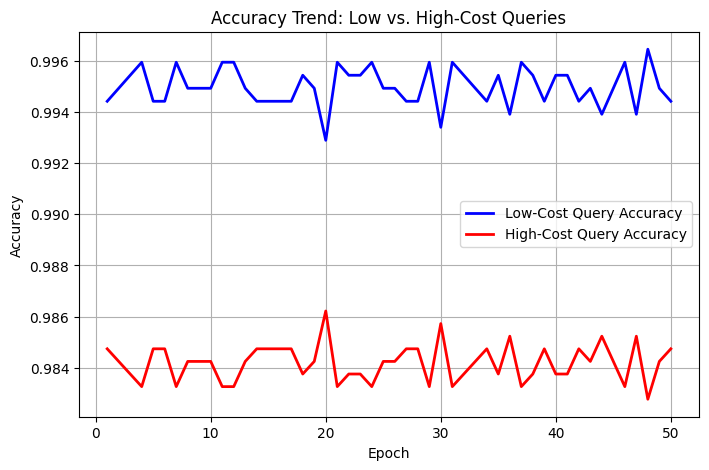

In [89]:
import matplotlib.pyplot as plt
import torch
import numpy as np

low_cost_accuracies, high_cost_accuracies = [], []

for epoch in range(num_epochs):
    correct_low, correct_high, total_low, total_high = 0, 0, 0, 0

    with torch.no_grad():
        for inputs, hints, costs in train_loader:
            hint_outputs, _ = model(inputs)
            _, predicted = torch.max(hint_outputs, 1)

            median_cost = costs.median()
            low_cost_idx = (costs < median_cost).nonzero(as_tuple=True)[0]
            high_cost_idx = (costs >= median_cost).nonzero(as_tuple=True)[0]

            if low_cost_idx.numel() > 0:  # Ensure indices are not empty
                correct_low += (predicted[low_cost_idx] == hints[low_cost_idx]).sum().item()
                total_low += len(low_cost_idx)

            if high_cost_idx.numel() > 0:
                correct_high += (predicted[high_cost_idx] == hints[high_cost_idx]).sum().item()
                total_high += len(high_cost_idx)

    # Compute accuracy and prevent division by zero
    low_cost_acc = correct_low / (total_low + 1e-8)
    high_cost_acc = correct_high / (total_high + 1e-8)

    low_cost_accuracies.append(low_cost_acc)
    high_cost_accuracies.append(high_cost_acc)

    # # Print Debugging Information
    # print(f"Epoch {epoch+1}:")
    # print(f"  Low-Cost Queries -> Accuracy: {low_cost_acc:.4f}, Samples: {total_low}")
    # print(f"  High-Cost Queries -> Accuracy: {high_cost_acc:.4f}, Samples: {total_high}")
    # print("-" * 50)

# **Plot Accuracy for Low-Cost vs. High-Cost Queries**
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), low_cost_accuracies, label="Low-Cost Query Accuracy", color='blue', linewidth=2)
plt.plot(range(1, num_epochs + 1), high_cost_accuracies, label="High-Cost Query Accuracy", color='red', linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Trend: Low vs. High-Cost Queries")
plt.legend()
plt.grid(True)
plt.show()


In [90]:
import pandas as pd
import torch

# Convert predictions to NumPy arrays if they are PyTorch tensors
if isinstance(predicted, torch.Tensor):
    predicted = predicted.detach().cpu().numpy()

if isinstance(cost_outputs, torch.Tensor):
    cost_predicted = cost_outputs.detach().cpu().numpy().flatten()
else:
    cost_predicted = cost_outputs

# Convert true labels to NumPy arrays
y_hints_true = y_hints_test_tensor.detach().cpu().numpy()
y_cost_true = y_cost_test_tensor.detach().cpu().numpy().flatten()

# Ensure y_hints_pred is properly formatted
y_hints_pred = predicted.flatten() if predicted.ndim > 1 else predicted

# Compare hint predictions with actual labels
print("\n🔍 Hint Prediction Analysis:")
print("Predicted Hints:", y_hints_pred)
print("Actual Hint Labels:", y_hints_true)

# Compare cost predictions with actual execution costs
print("\n💰 Execution Cost Analysis:")
print("Predicted Costs:", cost_predicted)
print("Actual Costs:", y_cost_true)

# Ensure 1D format for pandas Series
y_hints_pred_series = pd.Series(y_hints_pred.flatten()) if y_hints_pred.ndim > 1 else pd.Series(y_hints_pred)
cost_predicted_series = pd.Series(cost_predicted.flatten()) if cost_predicted.ndim > 1 else pd.Series(cost_predicted)

# Analyze the distribution of predicted hints
print("\n📊 Hint Prediction Distribution:")
print(y_hints_pred_series.value_counts())

# Analyze the distribution of predicted execution costs
print("\n📉 Cost Prediction Distribution:")
print(cost_predicted_series.describe())



🔍 Hint Prediction Analysis:
Predicted Hints: [ 5 19 20 37  0  2  1  0  1  2  4 18 20 20  3 20 19 21 36 20  0 36  1 19
 36  1  0 18 20  1 20  1]
Actual Hint Labels: [ 0 20  1 36  1 18  1  0 36 36 19  1 37  4  2  4  0  3 20 37 19 37  2 20
 19  3  4 36 20 20  2 20 20  1 20  0 20 36  3  3 20 19  0 38  2 37 37 18
 20  3  2 21 36 36 18 19 37  2 19  1 36 20 37 21 36  1  0  1 19 20 20  1
 19 20 37 20 37  1  0 22  1  1 20 19 20 20 36  2  1 36 20  3  0 19 36  0
 37 36 36 19 20  1  1  0 19  0  0  0 20 36 20  0  3  0  3  0 20  4  2 20
 36  2 21 20 36  0  1  4  3 20  1 20 37  0  3 37 20 19 21  1  0 36  1  0
  0 37 20  4 19 20  4  3  5  2 37  0  1  0 37 19 39 20  0  1 36  0  0 20
  2  2  5 21 20 37 36 21 19 37  0 36 21  5 38  2  2 18  3  1  0  4  1 21
 36  0 20 37 38  2 20  3 20  4  0  0  2 38 19  0  0 20 36  2 21  0 36 20
 19 18 20 20  4 20  2 36  4  2 19 36  2  1 37 21 36  0  2 37  1 21 36  1
 36  0  4  0  1 36  0  4  0 37  2 18 20 20 19 18  3  1  2  0 36 37 36 20
  0 20 20 39 21  1 20 37 20 20  

In [91]:
# Identify incorrect mappings in encoding.idx2type
incorrect_mappings = {key: value for key, value in encoding.idx2type.items() if isinstance(value, (int, float))}
print("Incorrect Mappings:", incorrect_mappings)

Incorrect Mappings: {13: 2, 14: 0, 16: 3, 17: 13, 18: 14, 19: 1, 20: 15, 21: 16, 22: 17, 23: 18, 24: 5, 25: 4, 26: 24, 27: 25, 28: 26, 29: 27, 30: 28, 31: 23, 32: 19, 33: 20, 34: 21, 35: 29, 36: 30, 37: 31, 38: 32, 39: 33, 40: 22, 41: 34, 42: 35, 43: 36, 44: 37, 45: 40, 46: 7, 47: 6, 48: 46, 49: 8, 50: 49, 51: 48, 52: 51, 53: 47, 54: 52, 55: 9, 56: 10, 57: 53, 58: 11, 59: 58, 60: 59, 61: 60, 62: 12, 63: 62, 64: 63}


In [92]:
# Fix incorrect mappings automatically
for key, value in incorrect_mappings.items():
    encoding.idx2type[key] = encoding.idx2type.get(value, f"Unknown ({value})")  # Replace or fallback

# Print the fixed mappings
print("Fixed idx2type Mappings:", encoding.idx2type)


Fixed idx2type Mappings: {0: 'Gather', 1: 'Hash Join', 2: 'Seq Scan', 3: 'Hash', 4: 'Bitmap Heap Scan', 5: 'Bitmap Index Scan', 6: 'Nested Loop', 7: 'Index Scan', 8: 'Merge Join', 9: 'Gather Merge', 10: 'Materialize', 11: 'BitmapAnd', 12: 'Sort', 13: 'Seq Scan', 14: 'Gather', 15: 'Inner', 16: 'Hash', 17: 'Seq Scan', 18: 'Gather', 19: 'Hash Join', 20: 'Inner', 21: 'Hash', 22: 'Seq Scan', 23: 'Gather', 24: 'Bitmap Index Scan', 25: 'Bitmap Heap Scan', 26: 'Bitmap Index Scan', 27: 'Bitmap Heap Scan', 28: 'Bitmap Index Scan', 29: 'Bitmap Heap Scan', 30: 'Bitmap Index Scan', 31: 'Gather', 32: 'Hash Join', 33: 'Inner', 34: 'Hash', 35: 'Bitmap Heap Scan', 36: 'Bitmap Index Scan', 37: 'Gather', 38: 'Hash Join', 39: 'Inner', 40: 'Seq Scan', 41: 'Hash', 42: 'Bitmap Heap Scan', 43: 'Bitmap Index Scan', 44: 'Gather', 45: 'Seq Scan', 46: 'Index Scan', 47: 'Nested Loop', 48: 'Index Scan', 49: 'Merge Join', 50: 'Merge Join', 51: 'Index Scan', 52: 'Index Scan', 53: 'Nested Loop', 54: 'Index Scan', 55: 


Sample Predictions with Costs:
Sample 1:
  True Knob: Gather | True Cost: 0.61
  Predicted Knob: Gather | Predicted Cost: 0.62
--------------------------------------------------
Sample 2:
  True Knob: Inner | True Cost: 0.86
  Predicted Knob: Inner | Predicted Cost: 0.86
--------------------------------------------------
Sample 3:
  True Knob: Hash Join | True Cost: 0.60
  Predicted Knob: Hash Join | Predicted Cost: 0.58
--------------------------------------------------
Sample 4:
  True Knob: Bitmap Index Scan | True Cost: 0.59
  Predicted Knob: Bitmap Index Scan | Predicted Cost: 0.66
--------------------------------------------------
Sample 5:
  True Knob: Hash Join | True Cost: 0.55
  Predicted Knob: Hash Join | Predicted Cost: 0.44
--------------------------------------------------
Sample 6:
  True Knob: Gather | True Cost: 0.41
  Predicted Knob: Gather | Predicted Cost: 0.40
--------------------------------------------------
Sample 7:
  True Knob: Hash Join | True Cost: 0.52
  P

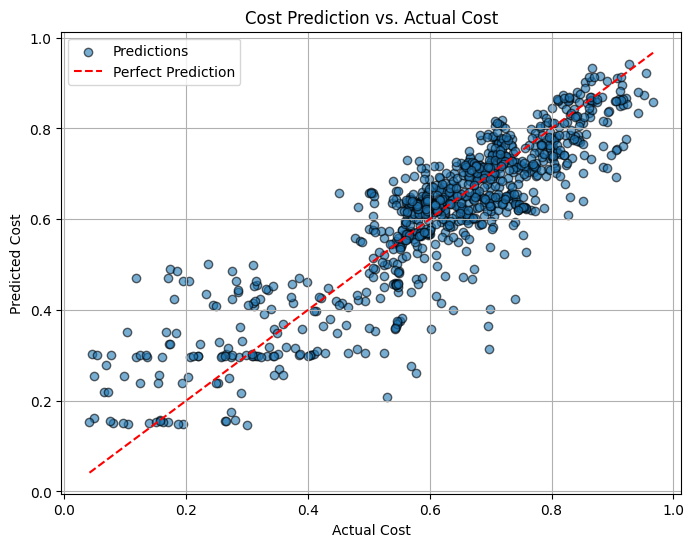

In [93]:
# Set model to evaluation mode
model.eval()
predicted_knobs = []
true_knobs = []
predicted_costs_list = []  # Temporary list for predicted costs
true_costs_list = []  # Temporary list for true costs
total_samples = 0
total_matches = 0
with torch.no_grad():
    # Get model predictions (both hint and cost)
    hint_outputs, cost_outputs = model(X_test_tensor)  

    # Convert logits to class indices for hint predictions
    _, predicted_hints = torch.max(hint_outputs, 1)  
    predicted_hints = predicted_hints.cpu().numpy()
    y_test_hints_np = y_hints_test_tensor.cpu().numpy()

    # Convert cost outputs to numpy (flattened for easier comparison)
    predicted_costs = cost_outputs.cpu().numpy().flatten()
    true_costs = y_cost_test_tensor.cpu().numpy().flatten()

# Convert numerical indices to knob names and store costs
for pred_idx, true_idx, pred_cost, true_cost in zip(predicted_hints, y_test_hints_np, predicted_costs, true_costs):
    true_knob = encoding.idx2type.get(true_idx, f"Unknown ({true_idx})")  # Handle missing mappings
    pred_knob = encoding.idx2type.get(pred_idx, f"Unknown ({pred_idx})")

    predicted_knobs.append(pred_knob)
    true_knobs.append(true_knob)
    predicted_costs_list.append(pred_cost)
    true_costs_list.append(true_cost)

       # Count matches
    total_samples += 1
    if pred_knob == true_knob:
        total_matches += 1

# Convert cost lists into NumPy arrays
predicted_costs = np.array(predicted_costs_list)
true_costs = np.array(true_costs_list)

# Print first 10 predictions with associated costs for verification
print("\nSample Predictions with Costs:")
for i in range(min(10, len(true_knobs))):
    print(f"Sample {i+1}:")
    print(f"  True Knob: {true_knobs[i]} | True Cost: {true_costs[i]:.2f}")
    # | True Cost: {true_costs[i]:.2f}
    print(f"  Predicted Knob: {predicted_knobs[i]} | Predicted Cost: {predicted_costs[i]:.2f}")
    print("-" * 50)

# Print total matches
match_percentage = (total_matches / total_samples) * 100
print(f"\nTotal Matches: {total_matches}/{total_samples} ({match_percentage:.2f}%)")


# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(true_costs, predicted_costs, alpha=0.6, edgecolors='k', label="Predictions")

# Plot y=x line for reference (Perfect Prediction Line)
plt.plot([min(true_costs), max(true_costs)], [min(true_costs), max(true_costs)], 
         color='red', linestyle='--', label="Perfect Prediction")

# Labels and title
plt.xlabel("Actual Cost")
plt.ylabel("Predicted Cost")
plt.title("Cost Prediction vs. Actual Cost")
plt.legend()
plt.grid(True)

#Show the plot
plt.show()

In [94]:
# Track mismatches
mismatch_count = 0
total_samples = len(true_knobs)

# Store mismatched samples with associated costs
mismatched_samples = []

for i in range(total_samples):
    if true_knobs[i] != predicted_knobs[i]:  # Identify mismatches
        mismatch_count += 1
        cost_diff = abs(true_costs[i] - predicted_costs[i])  # Calculate cost difference
        mismatched_samples.append((i + 1, true_knobs[i], predicted_knobs[i], true_costs[i], predicted_costs[i], cost_diff))

# Print mismatch details
if mismatched_samples:
    print("\nMismatched Predictions with Costs:")
    for i, true_knob, predicted_knob, true_cost, predicted_cost, cost_diff in mismatched_samples[:10]:  # Print first 10 mismatches
        print(f"Sample {i}: ❌ Mismatch")
        print(f"  True Knob: {true_knob} | True Cost: {true_cost:.2f}")
        print(f"  Predicted Knob: {predicted_knob} | Predicted Cost: {predicted_cost:.2f}")
        print(f"  Cost Difference: {cost_diff:.2f}")
        print("-" * 50)

# Print overall error rate and average cost difference
if total_samples > 0:
    error_rate = (mismatch_count / total_samples) * 100
    avg_cost_diff = sum([x[5] for x in mismatched_samples]) / mismatch_count if mismatch_count > 0 else 0
    print(f"\nTotal Mismatches: {mismatch_count}/{total_samples} ({error_rate:.2f}%)")
    print(f"Average Cost Difference for Mismatches: {avg_cost_diff:.2f}")
else:
    print("\nNo samples found.")



Mismatched Predictions with Costs:
Sample 19: ❌ Mismatch
  True Knob: Inner | True Cost: 0.71
  Predicted Knob: Hash | Predicted Cost: 0.61
  Cost Difference: 0.10
--------------------------------------------------
Sample 25: ❌ Mismatch
  True Knob: Hash Join | True Cost: 0.65
  Predicted Knob: Inner | Predicted Cost: 0.63
  Cost Difference: 0.02
--------------------------------------------------
Sample 80: ❌ Mismatch
  True Knob: Seq Scan | True Cost: 0.57
  Predicted Knob: Hash | Predicted Cost: 0.57
  Cost Difference: 0.00
--------------------------------------------------
Sample 113: ❌ Mismatch
  True Knob: Hash | True Cost: 0.65
  Predicted Knob: Inner | Predicted Cost: 0.61
  Cost Difference: 0.04
--------------------------------------------------
Sample 177: ❌ Mismatch
  True Knob: Hash Join | True Cost: 0.80
  Predicted Knob: Seq Scan | Predicted Cost: 0.79
  Cost Difference: 0.00
--------------------------------------------------
Sample 287: ❌ Mismatch
  True Knob: Hash | Tru

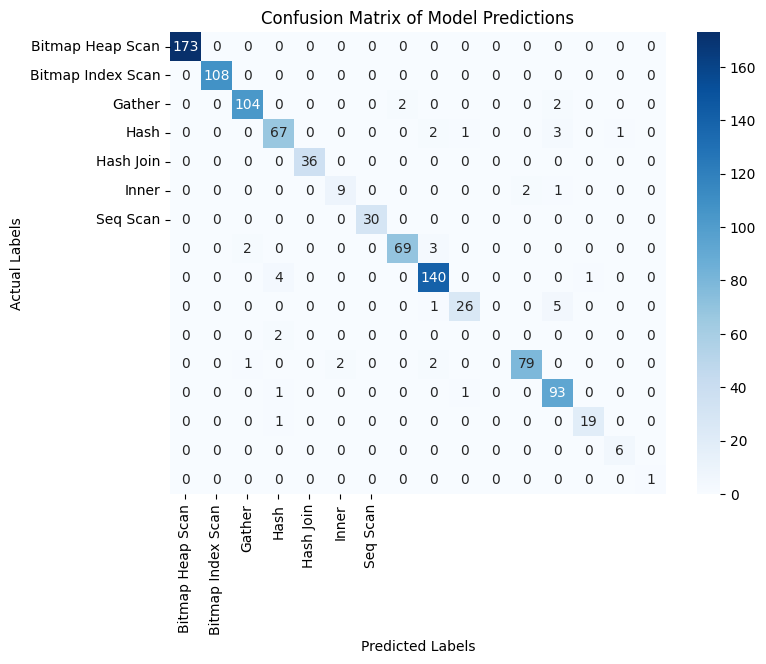


Average Cost Difference Per Knob Type (for Mismatches):
  Knob: Seq Scan → Avg Cost Difference: 0.03
  Knob: Hash → Avg Cost Difference: 0.05
  Knob: Bitmap Heap Scan → Avg Cost Difference: 0.00
  Knob: Inner → Avg Cost Difference: 0.10
  Knob: Bitmap Index Scan → Avg Cost Difference: 0.06
  Knob: Hash Join → Avg Cost Difference: 0.01
  Knob: Gather → Avg Cost Difference: 0.01


In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate Confusion Matrix
cm = confusion_matrix(y_hints_test_tensor.cpu().numpy(), predicted_hints)

# Initialize dictionary using unique true knob names instead of numerical labels
cost_diffs = {knob: [] for knob in set(true_knobs)}

# Track cost difference per knob type (for mismatches)
for i in range(len(true_knobs)):
    if true_knobs[i] != predicted_knobs[i]:  # Mismatch case
        if true_knobs[i] not in cost_diffs:
            cost_diffs[true_knobs[i]] = []  # Ensure key exists
        cost_diffs[true_knobs[i]].append(abs(true_costs[i] - predicted_costs[i]))

# Compute mean cost difference per knob type
avg_cost_diff_per_knob = {k: (sum(v) / len(v) if v else 0) for k, v in cost_diffs.items()}

# Create heatmap for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(set(true_knobs)), 
            yticklabels=sorted(set(predicted_knobs)))

plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix of Model Predictions")

# Display confusion matrix
plt.show()

# Print cost differences for mismatched predictions
print("\nAverage Cost Difference Per Knob Type (for Mismatches):")
for knob, avg_cost in avg_cost_diff_per_knob.items():
    print(f"  Knob: {knob} → Avg Cost Difference: {avg_cost:.2f}")


In [ ]:
from collections import defaultdict
import numpy as np

# Track cost differences for mismatched predictions
cost_diffs = defaultdict(list)

for i in range(len(true_knobs)):
    if true_knobs[i] != predicted_knobs[i]:  # Mismatch case
        cost_diffs[true_knobs[i]].append(abs(true_costs[i] - predicted_costs[i]))

# Compute mean cost difference per class
avg_cost_diff_per_class = {k: (sum(v) / len(v) if v else 0) for k, v in cost_diffs.items()}

# Print cost impact of misclassifications
print("\nAverage Cost Difference for Misclassified Hints:")
for hint, avg_cost in avg_cost_diff_per_class.items():
    print(f"  {hint}: {avg_cost:.2f} ms")

# Compute overall cost impact
total_cost_mismatch = sum([sum(v) for v in cost_diffs.values()])
print(f"\nTotal Cost Penalty due to Incorrect Hints: {total_cost_mismatch:.2f} ms")



Average Cost Difference for Misclassified Hints:
  Seq Scan: 0.05 ms
  Inner: 0.06 ms
  Hash Join: 0.01 ms
  Hash: 0.04 ms
  Bitmap Heap Scan: 0.01 ms
  Bitmap Index Scan: 0.08 ms
  Gather: 0.02 ms

Total Cost Penalty due to Incorrect Hints: 1.50 ms


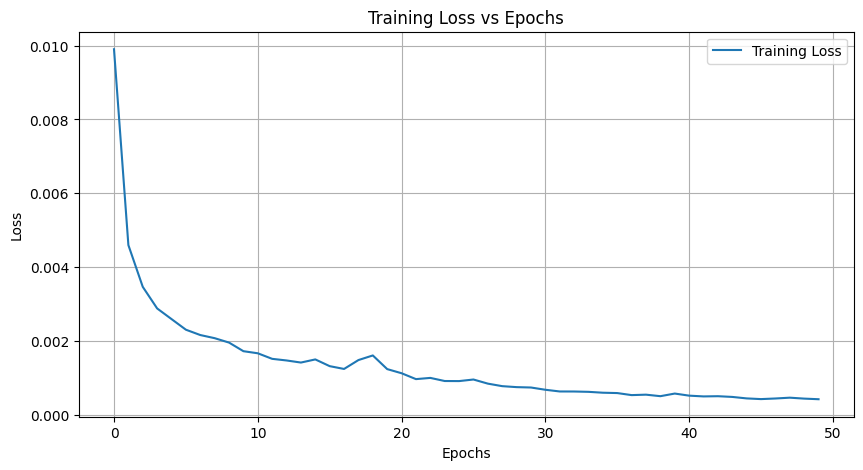

In [ ]:
# After training, plot the loss curve
# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()


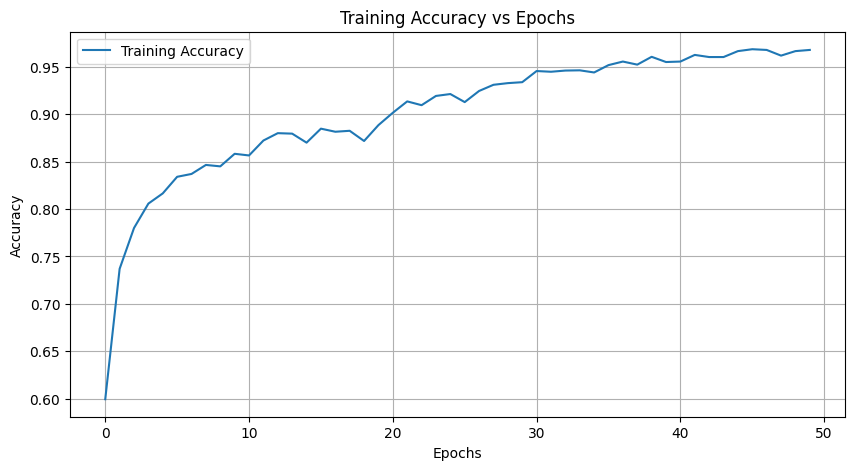

In [ ]:
# Plot Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

DCAP

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import r2_score
import time
from hybridmodel import QueryOptimizerModel
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_hints_train_tensor = torch.tensor(y_hints_train, dtype=torch.long)
y_cost_train_tensor = torch.tensor(y_cost_train, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_hints_test_tensor = torch.tensor(y_hints_test, dtype=torch.long)
y_cost_test_tensor = torch.tensor(y_cost_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_data = TensorDataset(X_train_tensor, y_hints_train_tensor, y_cost_train_tensor)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

num_hints = y_hints_train_tensor.max().item() + 1

# Enhanced Model
model = QueryOptimizerModel(input_size=X_train.shape[1], hidden_size=256, num_hints=num_hints, num_outputs=1)

# Loss Functions
hint_criterion = nn.CrossEntropyLoss()
contrastive_loss = nn.MSELoss()
cost_criterion = nn.MSELoss()
weight_history_dcap = []  # Store weight distributions over epochs

# Optimizer & Scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.0002, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

# 🔹 **Balanced Weighting: Prioritizing Low Execution Time but Keeping Full Query Space**
def compute_weighted_focus(costs, alpha=5.0, beta=0.5, min_weight=0.3):
    normalized_costs = (costs - costs.mean()) / (costs.std() + 1e-8)
    weights = torch.exp(alpha * -normalized_costs) + beta  # More weight to low-cost plans
    weights = (weights - weights.min()) / (weights.max() - weights.min())  # Normalize between 0 and 1
    weights = weights * (1 - min_weight) + min_weight  # Ensure all queries get at least `min_weight`
    return weights / torch.sum(weights)

# Training Loop
num_epochs = 50
epoch_times, total_losses = [], []
train_losses, train_accuracies, train_cost_losses, epoch_costs, cost_history, train_r2_scores = [], [], [], [], [], []
best_loss = float('inf')  # Initialize best loss with a high value
best_model_path = "out/best/best_model.pth"  # Path to save the best model

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    epoch_loss, epoch_cost_loss, correct, total = 0.0, 0.0, 0, 0
    all_cost_preds, all_cost_targets = [], []

    for inputs, hints, costs in train_loader:
        optimizer.zero_grad()
        
        hint_outputs, cost_outputs = model(inputs)
        costs = costs.squeeze(1)

        # Compute weights: Higher for low-cost queries, but keeping full query space
        weights = compute_weighted_focus(costs)
        epoch_weights.extend(weights.detach().cpu().numpy().flatten().tolist())  # Save weights

        # Compute losses
        hint_loss = hint_criterion(hint_outputs, hints)
        cost_loss = cost_criterion(cost_outputs, costs)
        target_one_hot = F.one_hot(hints, num_classes=hint_outputs.shape[1]).float()
        contrastive_hint_loss = contrastive_loss(hint_outputs, target_one_hot)

        # Apply weighted loss
        total_loss = torch.mean(weights * (0.8 * hint_loss + 0.6 * cost_loss + 0.05 * contrastive_hint_loss))

        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item() * inputs.size(0)
        epoch_cost_loss += cost_loss.item() * inputs.size(0)

        # ✅ Store cost predictions to avoid R² computation errors
        all_cost_preds.extend(cost_outputs.detach().cpu().numpy().flatten().tolist())
        all_cost_targets.extend(costs.detach().cpu().numpy().flatten().tolist())

        # ✅ Debugging: Print first 5 predictions in the first epoch
        if epoch == 0 and len(all_cost_preds) < 10:
            print(f"Sample Cost Predictions: {all_cost_preds[:5]}")
            print(f"Sample Cost Targets: {all_cost_targets[:5]}")

        _, predicted = torch.max(hint_outputs, 1)
        correct += (predicted == hints).sum().item()
        total += hints.size(0)

    avg_loss = epoch_loss / total
    avg_cost_loss = epoch_cost_loss / total
    accuracy = correct / total

    # ✅ Fix: Only compute R² if there are valid predictions
    if len(all_cost_targets) > 1 and len(all_cost_preds) > 1:
        train_r2 = r2_score(all_cost_targets, all_cost_preds)
    else:
        train_r2 = float("nan")  # Assign NaN if no valid predictions
        print("⚠️ Warning: No cost predictions found, skipping R² calculation.")

    total_losses.append(avg_loss)
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    train_cost_losses.append(avg_cost_loss)
    cost_history.append(epoch_costs)
    train_r2_scores.append(train_r2)

    scheduler.step()
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved at Epoch {epoch+1} with Loss: {avg_loss:.4f}")
    

    print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {avg_loss:.4f}, '
          f'Hint Accuracy: {accuracy*100:.2f}%, Cost Loss (MSE): {avg_cost_loss:.4f}, R²: {train_r2:.4f}')
weight_history_dcap.append(epoch_weights)  # Store for plotting later
# Evaluation on Test Set
model.eval()
with torch.no_grad():
    hint_outputs, cost_outputs = model(X_val_tensor)
    if y_cost_val_tensor.ndimension() > 1:
        y_cost_val_tensor = y_cost_val_tensor.squeeze(1)

    _, predicted = torch.max(hint_outputs, 1)
    hint_accuracy = (predicted == y_hints_val_tensor).sum().item() / y_hints_val_tensor.size(0)
    cost_mae = torch.abs(cost_outputs - y_cost_val_tensor).mean().item()

    # ✅ Fix: Ensure test R² is computed safely
    if y_cost_val_tensor.numel() > 1 and cost_outputs.numel() > 1:
        test_r2 = r2_score(y_cost_val_tensor.cpu().numpy().flatten(), cost_outputs.cpu().numpy().flatten())
    else:
        test_r2 = float("nan")
        print("⚠️ Warning: No valid test cost predictions, skipping R² calculation.")

    print(f"Test Hint Accuracy: {hint_accuracy * 100:.2f}%")
    print(f"Test Cost MAE: {cost_mae:.4f}")
    print(f"Test Cost R²: {test_r2:.4f}")


✅ Best model saved at Epoch 1 with Loss: 0.0134
Epoch [1/50], Total Loss: 0.0134, Hint Accuracy: 56.75%, Cost Loss (MSE): 0.1585, R²: -3.7046
✅ Best model saved at Epoch 2 with Loss: 0.0077
Epoch [2/50], Total Loss: 0.0077, Hint Accuracy: 73.02%, Cost Loss (MSE): 0.0975, R²: -1.8940
✅ Best model saved at Epoch 3 with Loss: 0.0063
Epoch [3/50], Total Loss: 0.0063, Hint Accuracy: 77.18%, Cost Loss (MSE): 0.0896, R²: -1.6584
✅ Best model saved at Epoch 4 with Loss: 0.0056
Epoch [4/50], Total Loss: 0.0056, Hint Accuracy: 80.35%, Cost Loss (MSE): 0.0839, R²: -1.4907
✅ Best model saved at Epoch 5 with Loss: 0.0052
Epoch [5/50], Total Loss: 0.0052, Hint Accuracy: 81.85%, Cost Loss (MSE): 0.0766, R²: -1.2745
✅ Best model saved at Epoch 6 with Loss: 0.0049
Epoch [6/50], Total Loss: 0.0049, Hint Accuracy: 82.65%, Cost Loss (MSE): 0.0666, R²: -0.9754
✅ Best model saved at Epoch 7 with Loss: 0.0046
Epoch [7/50], Total Loss: 0.0046, Hint Accuracy: 83.93%, Cost Loss (MSE): 0.0658, R²: -0.9521
✅ Best

In [283]:
model_path = "out/best/best_model.pth"
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mod

AdvancedQueryOptimizer(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=F

In [285]:
import numpy as np

# Assuming you already have y_cost_val_tensor (True Latency) and cost_outputs (Predicted Latency)

# Flatten the tensors into 1D arrays for ease of computation
true_latencies = y_cost_val_tensor.cpu().numpy().flatten()  # True Latency
predicted_latencies = cost_outputs.cpu().numpy().flatten()  # Predicted Latency

# Calculate the 90th percentile (P90) of the true latencies and predicted latencies
p90_true = np.percentile(true_latencies, 90)
p90_predicted = np.percentile(predicted_latencies, 90)

print(f"P90 True Latency: {p90_true:.4f}")
print(f"P90 Predicted Latency: {p90_predicted:.4f}")


P90 True Latency: 0.8279
P90 Predicted Latency: 0.7609


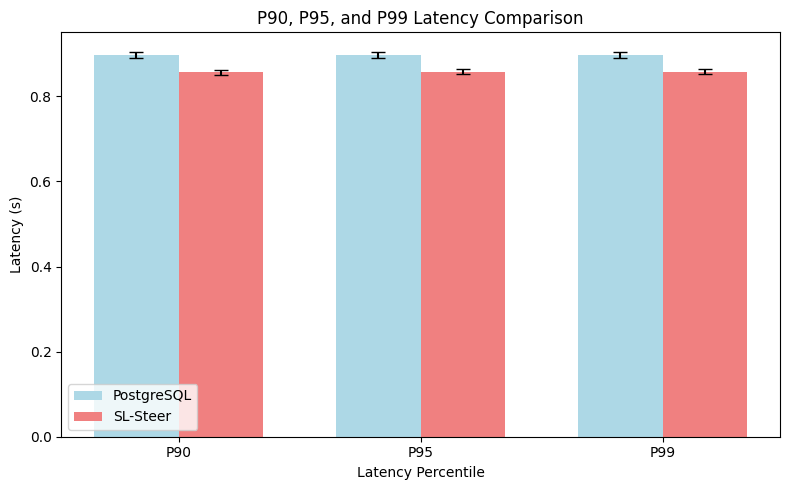

In [300]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'true_latency' and 'predicted_latency' are the arrays of latencies
true_latency = true_latencies # Example latencies, replace with your data
predicted_latency = predicted_latencies # Example predicted, replace with your data

# Calculate the P90, P95, P99 latencies
true_latency_p90 = np.percentile(true_latency, 90)
true_latency_p95 = np.percentile(true_latency, 95)
true_latency_p99 = np.percentile(true_latency, 99)

predicted_latency_p90 = np.percentile(predicted_latency, 90)
predicted_latency_p95 = np.percentile(predicted_latency, 95)
predicted_latency_p99 = np.percentile(predicted_latency, 99)

# Calculate standard deviation for error bars (for visualization)
true_latency_std = np.std(true_latency)
predicted_latency_std = np.std(predicted_latency)

# Plot the results in a bar chart
labels = ['P90', 'P95', 'P99']
true_latencies = [true_latency_p90, true_latency_p95, true_latency_p99]
predicted_latencies = [predicted_latency_p90, predicted_latency_p95, predicted_latency_p99]

# Create the bar plot
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 5))

# Plot bars for True Latency and Predicted Latency
rects1 = ax.bar(x - width/2, true_latencies, width, label='PostgreSQL', color='lightblue', yerr=true_latency_std, capsize=5)
rects2 = ax.bar(x + width/2, predicted_latencies, width, label='SL-Steer', color='lightcoral', yerr=predicted_latency_std, capsize=5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Latency Percentile')
ax.set_ylabel('Latency (s)')
ax.set_title('P90, P95, and P99 Latency Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()


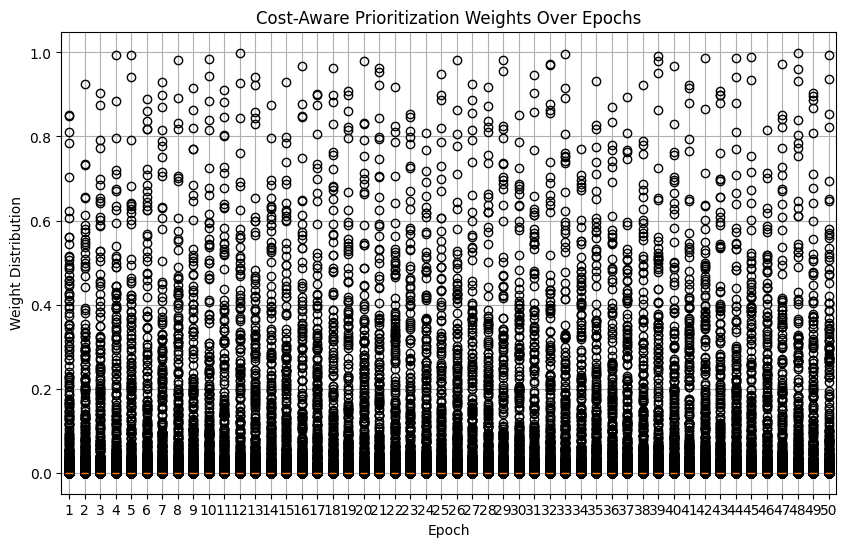

In [295]:
import matplotlib.pyplot as plt
import numpy as np

weight_history = []  # Store weight distributions

for epoch in range(num_epochs):
    epoch_weights = []

    for inputs, hints, costs in train_loader:
        weights = compute_weights(costs)
        epoch_weights.extend(weights.detach().cpu().numpy().flatten().tolist())  # Ensure 1D list

    weight_history.append(epoch_weights)  # Ensure list of lists

# Convert weight_history to a list of lists for plotting
weight_history = [np.array(epoch_weights).flatten().tolist() for epoch_weights in weight_history]

# **Plot Weight Distribution Over Epochs**
plt.figure(figsize=(10, 6))
plt.boxplot(weight_history, vert=True, patch_artist=True)
plt.xlabel("Epoch")
plt.ylabel("Weight Distribution")
plt.title("Cost-Aware Prioritization Weights Over Epochs")
plt.grid(True)
plt.show()



Sample Predictions with Costs:
Sample 1:
  True Knob: Bitmap Index Scan | True Cost: 0.61
  Predicted Knob: Bitmap Index Scan | Predicted Cost: 0.69
--------------------------------------------------
Sample 2:
  True Knob: Hash | True Cost: 0.61
  Predicted Knob: Hash | Predicted Cost: 0.62
--------------------------------------------------
Sample 3:
  True Knob: Gather | True Cost: 0.47
  Predicted Knob: Gather | Predicted Cost: 0.39
--------------------------------------------------
Sample 4:
  True Knob: Hash Join | True Cost: 0.55
  Predicted Knob: Hash Join | Predicted Cost: 0.53
--------------------------------------------------
Sample 5:
  True Knob: Inner | True Cost: 0.65
  Predicted Knob: Inner | Predicted Cost: 0.65
--------------------------------------------------
Sample 6:
  True Knob: Gather | True Cost: 0.09
  Predicted Knob: Gather | Predicted Cost: 0.22
--------------------------------------------------
Sample 7:
  True Knob: Gather | True Cost: 0.57
  Predicted Knob

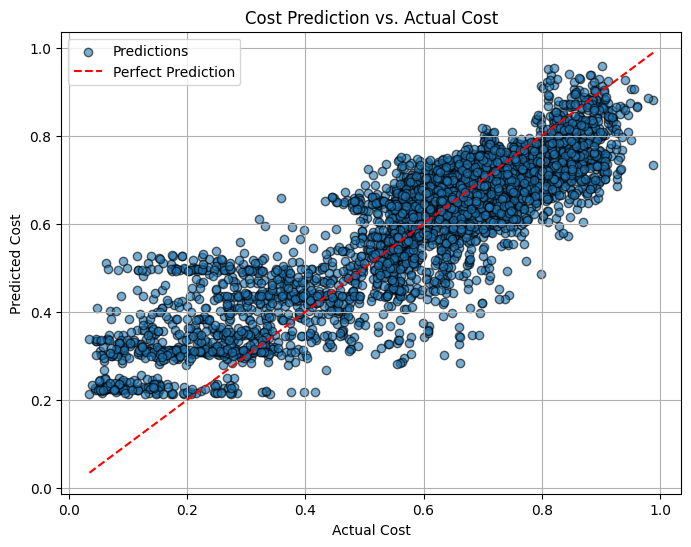

In [297]:
predicted_knobs = []
true_knobs = []
predicted_costs_list = []  # Temporary list for predicted costs
true_costs_list = []  # Temporary list for true costs
total_samples = 0
total_matches = 0
with torch.no_grad():
    # Get model predictions (both hint and cost)
    hint_outputs, cost_outputs = model(X_val_tensor)  

    # Convert logits to class indices for hint predictions
    _, predicted_hints = torch.max(hint_outputs, 1)  
    predicted_hints = predicted_hints.cpu().numpy()
    y_test_hints_np = y_hints_val_tensor.cpu().numpy()

    # Convert cost outputs to numpy (flattened for easier comparison)
    predicted_costs = cost_outputs.cpu().numpy().flatten()
    true_costs = y_cost_val_tensor.cpu().numpy().flatten()

# Convert numerical indices to knob names and store costs
for pred_idx, true_idx, pred_cost, true_cost in zip(predicted_hints, y_test_hints_np, predicted_costs, true_costs):
    true_knob = encoding.idx2type.get(true_idx, f"Unknown ({true_idx})")  # Handle missing mappings
    pred_knob = encoding.idx2type.get(pred_idx, f"Unknown ({pred_idx})")

    predicted_knobs.append(pred_knob)
    true_knobs.append(true_knob)
    predicted_costs_list.append(pred_cost)
    true_costs_list.append(true_cost)

       # Count matches
    total_samples += 1
    if pred_knob == true_knob:
        total_matches += 1

# Convert cost lists into NumPy arrays
predicted_costs = np.array(predicted_costs_list)
true_costs = np.array(true_costs_list)

# Print first 10 predictions with associated costs for verification
print("\nSample Predictions with Costs:")
for i in range(min(10, len(true_knobs))):
    print(f"Sample {i+1}:")
    print(f"  True Knob: {true_knobs[i]} | True Cost: {true_costs[i]:.2f}")
    # | True Cost: {true_costs[i]:.2f}
    print(f"  Predicted Knob: {predicted_knobs[i]} | Predicted Cost: {predicted_costs[i]:.2f}")
    print("-" * 50)

# Print total matches
match_percentage = (total_matches / total_samples) * 100
print(f"\nTotal Matches: {total_matches}/{total_samples} ({match_percentage:.2f}%)")


# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(true_costs, predicted_costs, alpha=0.6, edgecolors='k', label="Predictions")

# Plot y=x line for reference (Perfect Prediction Line)
plt.plot([min(true_costs), max(true_costs)], [min(true_costs), max(true_costs)], 
         color='red', linestyle='--', label="Perfect Prediction")

# Labels and title
plt.xlabel("Actual Cost")
plt.ylabel("Predicted Cost")
plt.title("Cost Prediction vs. Actual Cost")
plt.legend()
plt.grid(True)

#Show the plot
plt.show()

Without DCAP

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import r2_score
import numpy as np
import time
from hybridmodel import QueryOptimizerModel

weight_history_no_dcap = []  # Store uniform weight distributions over epochs
cost_threshold = 0.7  
low_cost_indices = np.where(y_cost_train < cost_threshold)[0]

# 🔹 Keep only low-cost queries for training
X_train_filtered = X_train[low_cost_indices]
y_hints_train_filtered = y_hints_train[low_cost_indices]
y_cost_train_filtered = y_cost_train[low_cost_indices]

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_filtered, dtype=torch.float32)
y_hints_train_tensor = torch.tensor(y_hints_train_filtered, dtype=torch.long)
y_cost_train_tensor = torch.tensor(y_cost_train_filtered, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_hints_test_tensor = torch.tensor(y_hints_test, dtype=torch.long)
y_cost_test_tensor = torch.tensor(y_cost_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_data = TensorDataset(X_train_tensor, y_hints_train_tensor, y_cost_train_tensor)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

num_hints = y_hints_train_tensor.max().item() + 1

# Enhanced Model
model = QueryOptimizerModel(input_size=X_train.shape[1], hidden_size=256, num_hints=num_hints, num_outputs=1)

# Loss Functions
hint_criterion = nn.CrossEntropyLoss()
contrastive_loss = nn.MSELoss()
cost_criterion = nn.MSELoss()

# Optimizer & Scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.0002, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

# 🔹 Training Loop (Without DCAP)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss, epoch_cost_loss, correct, total = 0.0, 0.0, 0, 0
    all_cost_preds, all_cost_targets = [], []

    for inputs, hints, costs in train_loader:
        optimizer.zero_grad()
        
        hint_outputs, cost_outputs = model(inputs)
        costs = costs.squeeze(1)

        # Compute losses (Without DCAP weighting)
        hint_loss = hint_criterion(hint_outputs, hints)
        cost_loss = cost_criterion(cost_outputs, costs)
        target_one_hot = F.one_hot(hints, num_classes=hint_outputs.shape[1]).float()
        contrastive_hint_loss = contrastive_loss(hint_outputs, target_one_hot)

        total_loss = 0.8 * hint_loss + 0.6 * cost_loss + 0.05 * contrastive_hint_loss  

        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item() * inputs.size(0)
        epoch_cost_loss += cost_loss.item() * inputs.size(0)
        
        all_cost_preds.extend(cost_outputs.detach().cpu().numpy().flatten().tolist())
        all_cost_targets.extend(costs.detach().cpu().numpy().flatten().tolist())

        _, predicted = torch.max(hint_outputs, 1)
        correct += (predicted == hints).sum().item()
        total += hints.size(0)

    avg_loss = epoch_loss / total
    avg_cost_loss = epoch_cost_loss / total
    accuracy = correct / total
    train_r2 = r2_score(all_cost_targets, all_cost_preds)

    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {avg_loss:.4f}, '
          f'Hint Accuracy: {accuracy*100:.2f}%, Cost Loss (MSE): {avg_cost_loss:.4f}')
weight_history_no_dcap.append(epoch_weights)  # Store for plotting later

# 🔹 Evaluation on Test Set (Without DCAP)
model.eval()
with torch.no_grad():
    hint_outputs, cost_outputs = model(X_test_tensor)
    y_cost_test_tensor = y_cost_test_tensor.squeeze(1)

    _, predicted = torch.max(hint_outputs, 1)
    hint_accuracy = (predicted == y_hints_test_tensor).sum().item() / y_hints_test_tensor.size(0)
    cost_mae = torch.abs(cost_outputs - y_cost_test_tensor).mean().item()
    test_r2 = r2_score(y_cost_test_tensor.cpu().numpy().flatten(), cost_outputs.cpu().numpy().flatten())

    print(f"Test Hint Accuracy: {hint_accuracy * 100:.2f}%")
    print(f"Test Cost MAE: {cost_mae:.4f}")
    print(f"Test Cost R²: {test_r2:.4f}")


Epoch [1/50], Total Loss: 1.6470, Hint Accuracy: 60.29%, Cost Loss (MSE): 0.1488
Epoch [2/50], Total Loss: 0.9915, Hint Accuracy: 72.61%, Cost Loss (MSE): 0.0996
Epoch [3/50], Total Loss: 0.8168, Hint Accuracy: 75.98%, Cost Loss (MSE): 0.0916
Epoch [4/50], Total Loss: 0.6995, Hint Accuracy: 80.72%, Cost Loss (MSE): 0.0813
Epoch [5/50], Total Loss: 0.6265, Hint Accuracy: 82.59%, Cost Loss (MSE): 0.0797
Epoch [6/50], Total Loss: 0.5844, Hint Accuracy: 84.01%, Cost Loss (MSE): 0.0719
Epoch [7/50], Total Loss: 0.5368, Hint Accuracy: 85.20%, Cost Loss (MSE): 0.0681
Epoch [8/50], Total Loss: 0.4730, Hint Accuracy: 87.87%, Cost Loss (MSE): 0.0630
Epoch [9/50], Total Loss: 0.4484, Hint Accuracy: 88.37%, Cost Loss (MSE): 0.0606
Epoch [10/50], Total Loss: 0.4228, Hint Accuracy: 88.91%, Cost Loss (MSE): 0.0540
Epoch [11/50], Total Loss: 0.4079, Hint Accuracy: 89.56%, Cost Loss (MSE): 0.0544
Epoch [12/50], Total Loss: 0.3992, Hint Accuracy: 89.44%, Cost Loss (MSE): 0.0511
Epoch [13/50], Total Loss

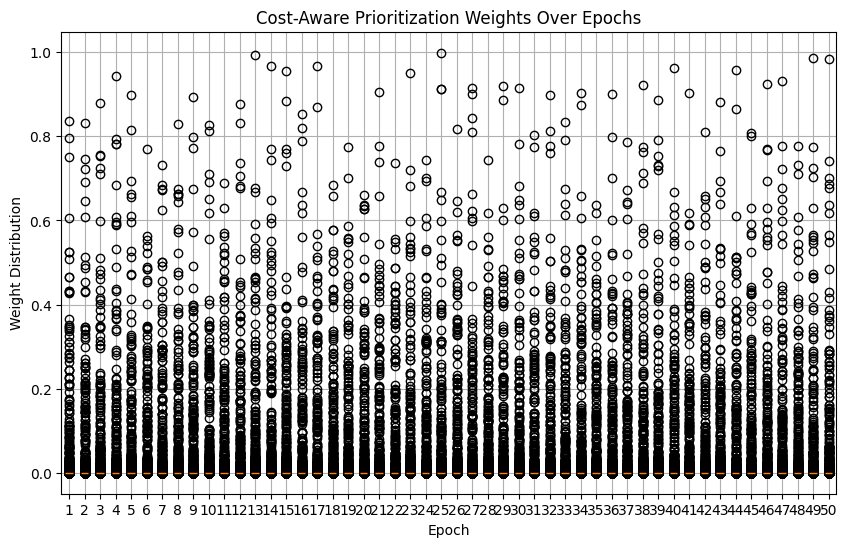

In [123]:
import matplotlib.pyplot as plt
import numpy as np

weight_history = []  # Store weight distributions

for epoch in range(num_epochs):
    epoch_weights = []

    for inputs, hints, costs in train_loader:
        weights = compute_weights(costs)
        epoch_weights.extend(weights.detach().cpu().numpy().flatten().tolist())  # Ensure 1D list

    weight_history.append(epoch_weights)  # Ensure list of lists

# Convert weight_history to a list of lists for plotting
weight_history = [np.array(epoch_weights).flatten().tolist() for epoch_weights in weight_history]

# **Plot Weight Distribution Over Epochs**
plt.figure(figsize=(10, 6))
plt.boxplot(weight_history, vert=True, patch_artist=True)
plt.xlabel("Epoch")
plt.ylabel("Weight Distribution")
plt.title("Cost-Aware Prioritization Weights Over Epochs")
plt.grid(True)
plt.show()
